In [13]:
import pymc
import numpy as np
rng = np.random.RandomState(1769)

# True model parameters, known only by nature
true_H_ex = 7e3
true_S_ex = 5

# Some generated "observed" data
# Dataset 1
n1 = 1000
dataset1 = {
'n': n1,
'x_a': rng.random_sample((n1,)),
'T': 1200 * rng.random_sample((n1,)) + 300
}
dataset1['x_b'] = 1 - dataset1['x_a']
# Dataset 2
n2 = 1000
dataset2 = {
'n': n2,
'x_a': rng.random_sample((n2,)),
'T': 300.
}
dataset2['x_b'] = 1 - dataset2['x_a']

# Observed energies: true energy plus noise
noise1 = 0#rng.normal(loc=0.1*8.3145*dataset1['T'], scale=100, size=dataset1['n'])
noise2 = 0#rng.normal(loc=0.1*8.3145*dataset2['T'], scale=100, size=dataset2['n'])
dataset1['energy'] = 8.3145*dataset1['T']*(dataset1['x_a']*np.log(dataset1['x_a'])+dataset1['x_b']*np.log(dataset1['x_b'])) + (true_H_ex - dataset1['T']*true_S_ex)*dataset1['x_a']*dataset1['x_b'] + noise1
dataset2['energy'] = 8.3145*dataset2['T']*(dataset2['x_a']*np.log(dataset2['x_a'])+dataset2['x_b']*np.log(dataset2['x_b'])) + (true_H_ex - dataset2['T']*true_S_ex)*dataset2['x_a']*dataset2['x_b'] + noise2

datasets = [dataset1, dataset2]

In [14]:
# Priors on unknown parameters
H_ex = pymc.Normal('H_ex', 0., 1./(1e4**2), value=6e3)
S_ex = pymc.Normal('S_ex', 0., 1./(20**2), value=2)
L2_ex = 0#pymc.Laplace('L2_ex', 0, 1, value=0)


# Binary regular solution
def energy(H_ex, S_ex, L2_ex, T, x_a, x_b):
    return 8.3145*T*(x_a*np.log(x_a)+x_b*np.log(x_b)) + (H_ex - T*S_ex+L2_ex*T**3)*x_a*x_b

def entropy(H_ex, S_ex, L2_ex, T, x_a, x_b):
    return -(8.3145*(x_a*np.log(x_a)+x_b*np.log(x_b)) + (-S_ex)*x_a*x_b)

def enthalpy(H_ex, S_ex, L2_ex, T, x_a, x_b):
    return energy(H_ex, S_ex, L2_ex, T, x_a, x_b) + T*entropy(H_ex, S_ex, L2_ex, T, x_a, x_b)

# Fit to our energy model
@pymc.potential(plot=True)
def error(H_ex=H_ex, S_ex=S_ex, L2_ex=L2_ex, value=datasets):
    result = np.zeros_like(datasets)
    for idx, dataset in enumerate(datasets):
        result[idx] = np.abs(energy(H_ex, S_ex, L2_ex, dataset['T'], dataset['x_a'], dataset['x_b']) - dataset['energy']).mean()
    return -result.sum()


In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('bmh')
mod = pymc.Model([H_ex, S_ex, error])
map_ = pymc.MAP(mod).fit()
MDL = pymc.MCMC(mod)
MDL.sample(iter=50000, burn=30000, thin=5, burn_till_tuned=True, progress_bar=False)

Plotting H_ex
Plotting S_ex


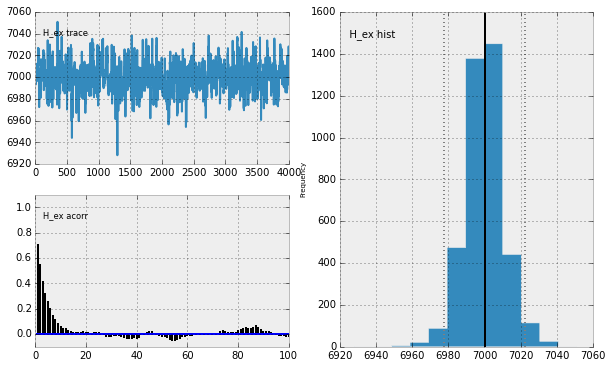

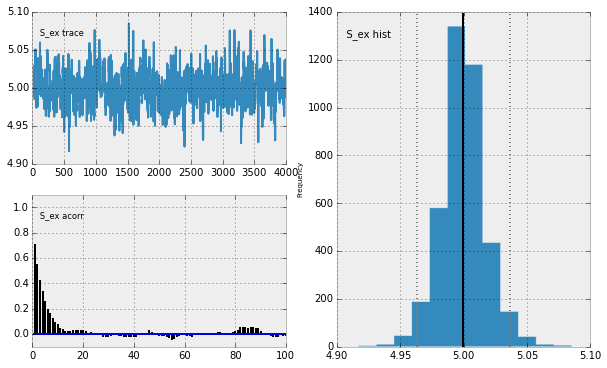

In [16]:
pymc.Matplot.plot(MDL)

In [11]:
print(MDL.stats()['H_ex']['95% HPD interval'])
print(MDL.stats()['S_ex']['95% HPD interval'])

[ 6933.92458912  7268.82995791]
[ 0.98164798  1.52218604]


/home/rotis/anaconda/envs/mc/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


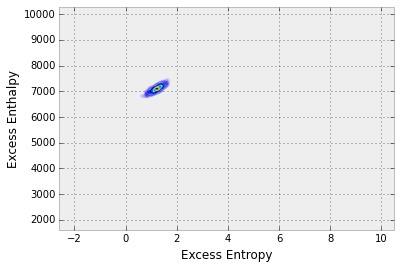

In [12]:
plt.scatter(S_ex.trace(), H_ex.trace(), alpha=0.1, zorder=1)
import scipy.stats
gkde = scipy.stats.gaussian_kde([S_ex.trace(), H_ex.trace()])
x,y = np.mgrid[-2:10:0.1, 2000:10000:100]
z = np.array(gkde.evaluate([x.flatten(),y.flatten()])).reshape(x.shape)
plt.contour(x, y, z, linewidths=1, zorder=2)
plt.xlabel('Excess Entropy')
plt.ylabel('Excess Enthalpy')

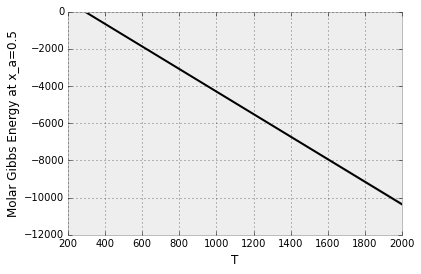

In [19]:
S_ex_tr, H_ex_tr = (S_ex.trace(), H_ex.trace())
Tfit = np.linspace(300, 2000, 100)
Efit = energy(H_ex_tr[:, None], S_ex_tr[:, None], L2_ex, Tfit, 0.5, 0.5)
mu = Efit.mean(axis=0)
sig = 2 * Efit.std(axis=0)
plt.plot(Tfit, mu, '-k')
plt.fill_between(Tfit, mu - sig, mu + sig, color='lightgray')

plt.xlabel('T')
plt.ylabel('Molar Gibbs Energy at x_a=0.5')

In [20]:
temp = 300 # temperature of interest

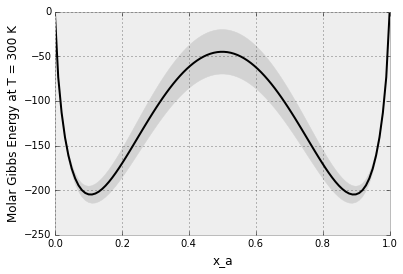

In [21]:
S_ex_tr, H_ex_tr = (S_ex.trace(), H_ex.trace())
xfit = np.linspace(1e-8, 1.-1e-8, 100)
yfit = energy(H_ex_tr[:, None], S_ex_tr[:, None], L2_ex, temp, xfit, 1-xfit)
mu = yfit.mean(axis=0)
sig = 2 * yfit.std(axis=0)
plt.plot(xfit, mu, '-k')
plt.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

plt.xlim(0,1)
plt.xlabel('x_a')
plt.ylabel('Molar Gibbs Energy at T = {} K'.format(temp))

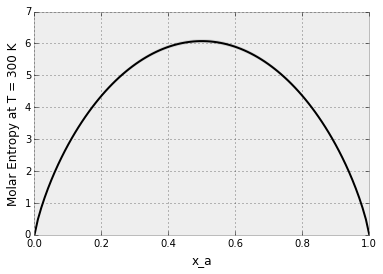

In [22]:
S_ex_tr, H_ex_tr = (S_ex.trace(), H_ex.trace())
xfit = np.linspace(1e-8, 1.-1e-8, 100)
yfit = entropy(H_ex_tr[:, None], S_ex_tr[:, None], L2_ex, temp, xfit, 1-xfit)
mu = yfit.mean(axis=0)
sig = 2 * yfit.std(axis=0)
plt.plot(xfit, mu, '-k')
plt.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

plt.xlabel('x_a')
plt.ylabel('Molar Entropy at T = {} K'.format(temp))

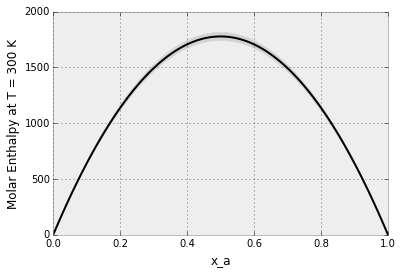

In [23]:
S_ex_tr, H_ex_tr = (S_ex.trace(), H_ex.trace())
xfit = np.linspace(1e-8, 1.-1e-8, 100)
yfit = enthalpy(H_ex_tr[:, None], S_ex_tr[:, None], L2_ex, temp, xfit, 1-xfit)
mu = yfit.mean(axis=0)
sig = 2 * yfit.std(axis=0)
plt.plot(xfit, mu, '-k')
plt.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

plt.xlabel('x_a')
plt.ylabel('Molar Enthalpy at T = {} K'.format(temp))

In [24]:
MDL._calc_bpic()

646.89095568595417